In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

pd.set_option('display.max_columns', 100)
%matplotlib inline  
plt.style.use('fivethirtyeight')

In [ ]:
#DOUBTS
#How to decide if credit_history variable is non-numerical?
#Ans:-credit_history is a nominal variable
#How to print multiple graphs in one figure
# is credit_history category or bindary or interval variable?
#Ans:-credit_history is a nominal variable
# is gender, married etc. are careorical or binary variable?
#Ans:-gender, married etc are nominal variables
# is dependents is a oridnal varialble or categorical variable
#Ans:-dependents is nominal variable
# is loan status is binary or categorical variable?
#Ans:-loan_status is nominal variable

#TODOs
#write a loop to print multiple graphs for all numerical variables against all categorical variables 
#to analyze infomration in more detail
# TODO:create plot of loan status of applicants using credit history and gender variable stacked together.i.e 
#You can also add gender into the mix  HOW????
#Write a code to plot the graph to test this -A key hypothesis is that the whether a person is educated or 
#self-employed can combine to give a good estimate of loan amount.

In [33]:
df=pd.read_csv("./input/train.csv")
#test=pd.read_csv("./input/test.csv")
df.head()
#train.tail()
#df.describe() # Get summary of numerical variables
#df.shape
#df.dtypes
#df.info()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [34]:
#Create a meta data table to distinguish levels of data columns
data = []
for f in df.columns:
    # Defining the role
    if f == 'Loan_Status':
        role = 'target'
    elif f == 'Loan_ID':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if f == 'Gender' or f == 'Married' or f == 'Education' or f == 'Credit_History' or f == 'Self_Employed' or f == 'Property_Area' or f == 'Loan_Status':
        level = 'nominal' 
    elif df[f].dtype == 'int64' :
        level = 'interval'
    elif df[f].dtype == 'float64' and f != 'Credit_History':
        level = 'ratio'
    elif   f == 'Loan_ID' or f == 'Dependents':
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    #if f == 'Loan_ID':
     #   keep = False
    
    # Defining the data type 
    dtype = df[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
Loan_ID,id,ordinal,True,object
Gender,input,nominal,True,object
Married,input,nominal,True,object
Dependents,input,ordinal,True,object
Education,input,nominal,True,object
Self_Employed,input,nominal,True,object
ApplicantIncome,input,interval,True,int64
CoapplicantIncome,input,ratio,True,float64
LoanAmount,input,ratio,True,float64


In [4]:
#Check for missing values on data
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
#Check the value counts of nominal variables
v = meta[(meta.level == 'nominal' ) | (meta.level == 'ordinal') & (meta.keep)].index
for f in v:
    dist_values = df[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable Loan_ID has 614 distinct values
Variable Gender has 2 distinct values
Variable Married has 2 distinct values
Variable Dependents has 4 distinct values
Variable Education has 2 distinct values
Variable Self_Employed has 2 distinct values
Variable Credit_History has 2 distinct values
Variable Property_Area has 3 distinct values
Variable Loan_Status has 2 distinct values


In [11]:
v = meta[(meta.level == 'nominal' ) & (meta.keep)].index
for f in v:
    dist_values = df[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable Gender has 2 distinct values
Variable Married has 2 distinct values
Variable Education has 2 distinct values
Variable Self_Employed has 2 distinct values
Variable Credit_History has 2 distinct values
Variable Property_Area has 3 distinct values
Variable Loan_Status has 2 distinct values


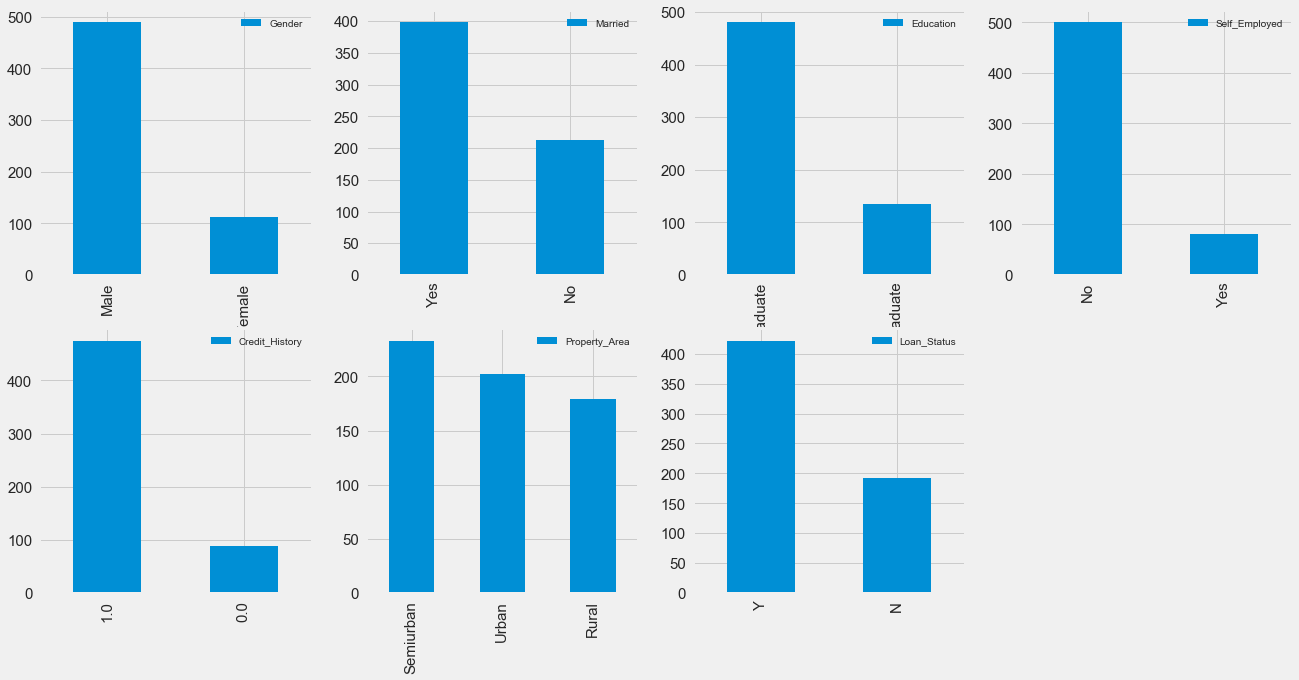

In [138]:
#plot nominal variables
v = meta[(meta.level == 'nominal' ) & (meta.keep)].index
fig = plt.figure()
i=1
for f in v:
    axi = fig.add_subplot(2, 4,i)
    df[f].value_counts().sort_values(ascending=False).head(20).plot(kind='bar',fontsize=15,legend='true',figsize=(20, 10),ax=axi)
    i=i+1   


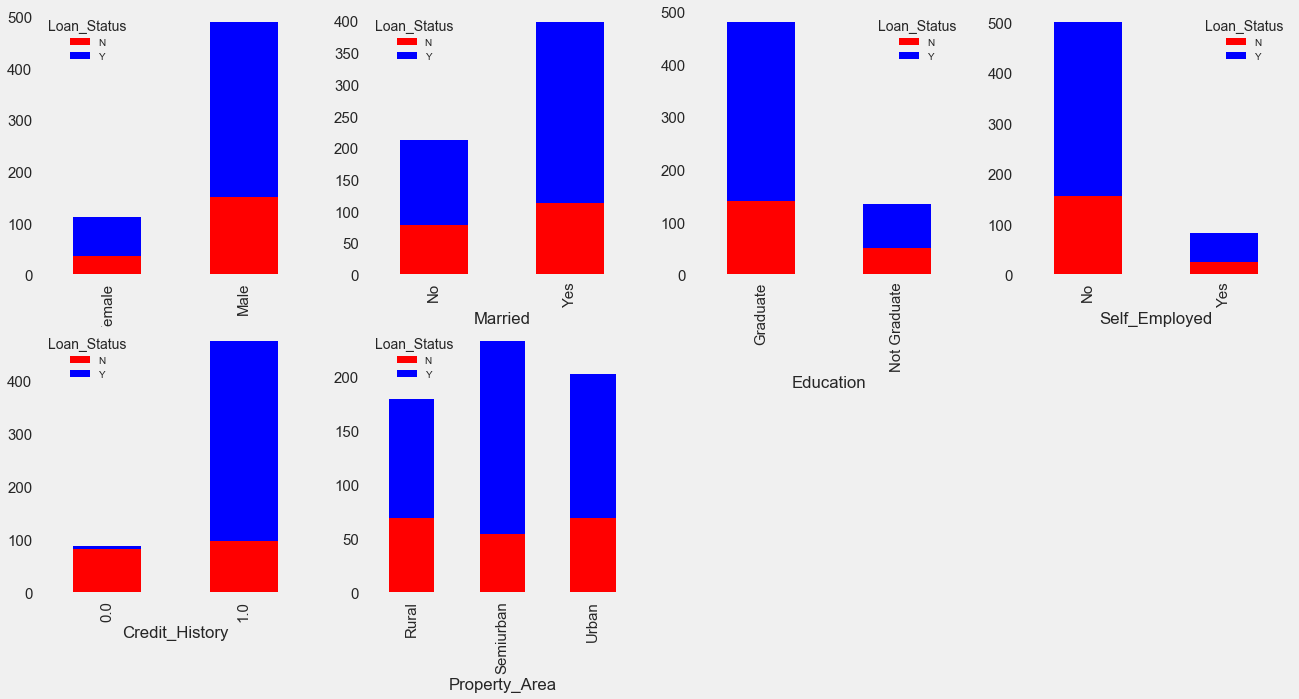

In [140]:
#plot nominal variables with target variable information
v = meta[(meta.level == 'nominal' ) & (meta.keep)].index
fig = plt.figure()
i=1
for f in v:
    if f != 'Loan_Status' :
        axi = fig.add_subplot(2, 4,i)
        temp = pd.crosstab(df[f], df['Loan_Status'])
        #df[f].value_counts().sort_values(ascending=False).head(20).plot(kind='bar',fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=False,fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        i=i+1



In [133]:
#Get summary of numerical variables
v = meta[( meta.level == 'ratio') | (meta.level == 'interval') & (meta.keep)].index
df[v].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,592.000000,600.00000
mean,5403.459283,1621.245798,146.412162,342.00000
std,6109.041673,2926.248369,85.587325,65.12041
min,150.000000,0.000000,9.000000,12.00000
25%,2877.500000,0.000000,100.000000,360.00000
50%,3812.500000,1188.500000,128.000000,360.00000
75%,5795.000000,2297.250000,168.000000,360.00000
max,81000.000000,41667.000000,700.000000,480.00000


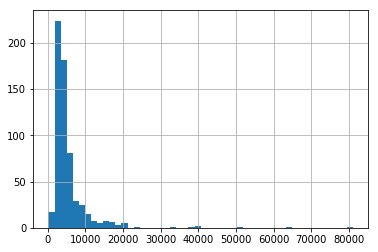

In [7]:
df['ApplicantIncome'].hist(bins=50)

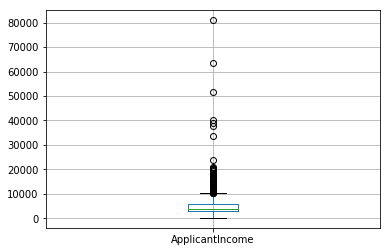

In [8]:
df.boxplot(column='ApplicantIncome')

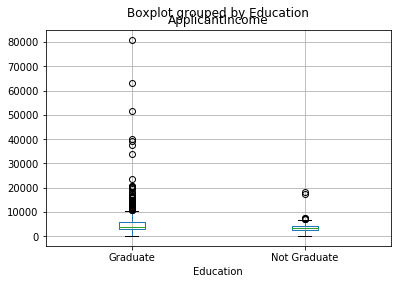

In [9]:
df.boxplot(column='ApplicantIncome', by = 'Education')

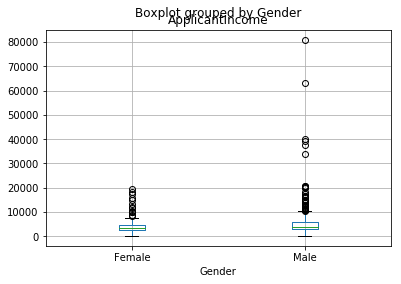

In [10]:
df.boxplot(column='ApplicantIncome', by = 'Gender')

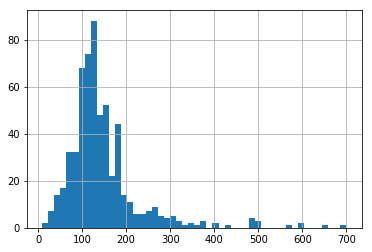

In [11]:
df['LoanAmount'].hist(bins=50)

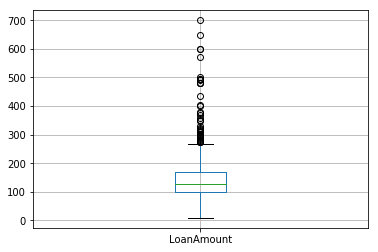

In [12]:
df.boxplot(column='LoanAmount')

In [31]:
temp1 = df['Credit_History'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print('Frequency Table for Credit History:') 
print (temp1)

print ('\nProbility of getting loan for each Credit History class:') 
print (temp2)




Frequency Table for Credit History:
0.0     89
1.0    475
Name: Credit_History, dtype: int64

Probility of getting loan for each Credit History class:
                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789
                       Loan_Status
Credit_History Gender             
0.0            Female     0.058824
               Male       0.086957
1.0            Female     0.761905
               Male       0.803665


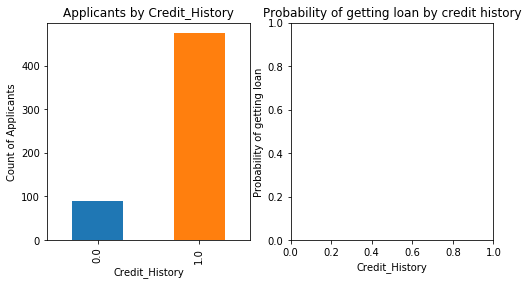

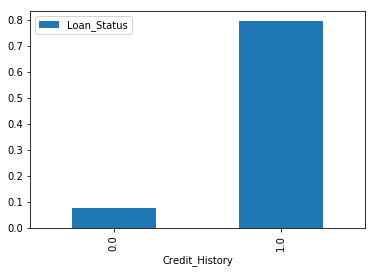

In [22]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Credit_History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title("Applicants by Credit_History")
temp1.plot(kind='bar')

ax2 = fig.add_subplot(122)

ax2.set_xlabel('Credit_History')
ax2.set_ylabel('Probability of getting loan')
ax2.set_title("Probability of getting loan by credit history")
temp2.plot(kind = 'bar')

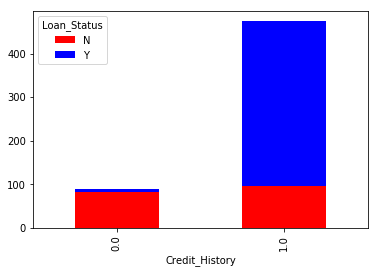

In [20]:
temp3 = pd.crosstab(df['Credit_History'], df['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

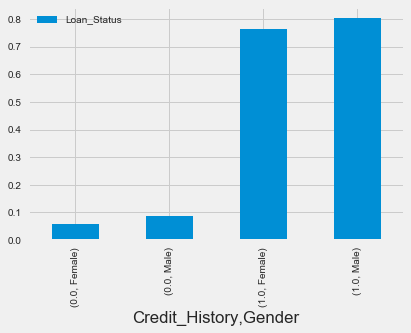

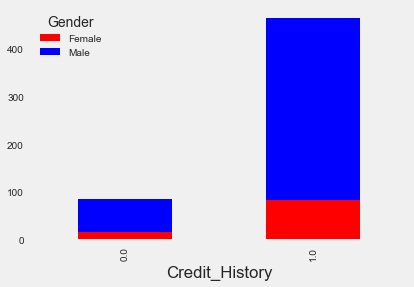

In [141]:


temp4 = df.pivot_table(values='Loan_Status',index=['Credit_History','Gender'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
#print(temp4)
temp4.plot(kind = 'bar')
temp4 = pd.crosstab(df['Credit_History'], df['Gender'])
temp4.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)


In [36]:
#find missing values
df.apply(lambda x: sum(x.isnull()),axis=0) 

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [37]:
df['Dependents'].value_counts()

0     360
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [38]:
df['Loan_Amount_Term'].value_counts()

360.0    526
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [34]:
df['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [35]:
#Impute missing values of non numeric variables :Gender, Married, Dependents, Loan_Amount_Term, Credit_History

df['Gender'].fillna(mode(df['Gender'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Married'].fillna(mode(df['Married'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Self_Employed'].fillna(mode(df['Self_Employed'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Dependents'].fillna(mode(df['Dependents'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Loan_Amount_Term'].fillna(mode(df['Loan_Amount_Term'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Credit_History'].fillna(mode(df['Credit_History'].dropna(axis=0, how='any')).mode[0], inplace=True)

c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [32]:
#Impute missing values of LoanAmount
table = df.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
# Define function to return value of this pivot_table
def fage(x):
 return table.loc[x['Self_Employed'],x['Education']]

# Replace missing values
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

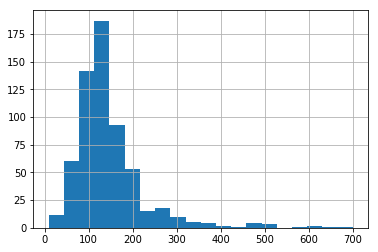

In [41]:
df['LoanAmount'].hist(bins=20)

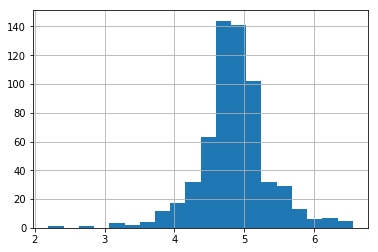

In [58]:
 df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20)

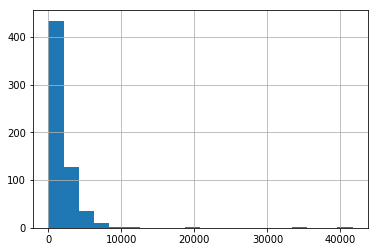

In [42]:
df['CoapplicantIncome'].hist(bins=20)

In [59]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])
#df['TotalIncome_log'].hist(bins=20) 
df = df.reset_index()

In [40]:
#Convert categorical data to numeric data
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes 


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,130.0,360.0,1.0,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


In [60]:
df.head()

,level_0,index,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,TotalIncome_log,LoanAmount_log
0,0,0,LP001002,1,0,0,0,0,5849,0.0,130.0,360.0,1.0,2,1,5849.0,8.674026,4.867534
1,1,1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0,6091.0,8.714568,4.852030
2,2,2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1,3000.0,8.006368,4.189655
3,3,3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1,4941.0,8.505323,4.787492
4,4,4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1,6000.0,8.699515,4.948760


In [48]:
#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(data.shape[0], n_folds=5)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
  print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome]) 

In [51]:
outcome_var = 'Loan_Status'
model = LogisticRegression()
predictor_var = ['Credit_History']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.946%


In [52]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.946%


In [62]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area','LoanAmount_log','TotalIncome_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.946%


In [63]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area','LoanAmount','TotalIncome']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.293%
Cross-Validation Score : 80.457%


In [64]:
#Generally we expect the accuracy to increase on adding variables. But this is a more challenging case. The accuracy and cross-validation score are not getting impacted by less important variables. Credit_History is dominating the mode. We have two options now:
#   Feature Engineering: dereive new information and try to predict those. I will leave this to your creativity.
#    Better modeling techniques. Let’s explore this next.

In [65]:
model = DecisionTreeClassifier()
predictor_var = ['Credit_History','Gender','Married','Education']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.946%


In [66]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Loan_Amount_Term','LoanAmount_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 88.925%
Cross-Validation Score : 69.046%


In [67]:
#An advantage with Random Forest is that we can make it work with all the features 
#and it returns a feature importance matrix which can be used to select features.
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 78.018%


In [ ]:
#Here we see that the accuracy is 100% for the training set. This is the ultimate case of overfitting and can be resolved in two ways:
#    Reducing the number of predictors
#    Tuning the model parameters
#Let’s try both of these. First we see the feature importance matrix from which we’ll take the most important features.

In [69]:
#Create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print(featimp)

Credit_History      0.272025
TotalIncome_log     0.267744
LoanAmount_log      0.223618
Dependents          0.052626
Property_Area       0.049829
Loan_Amount_Term    0.042245
Married             0.026223
Education           0.023678
Gender              0.021217
Self_Employed       0.020795
dtype: float64


In [76]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['TotalIncome_log','LoanAmount_log','Credit_History','Dependents','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 82.899%
Cross-Validation Score : 80.948%


In [79]:
''' This exercise gives us some very interesting and unique learning:

#    Using a more sophisticated model does not guarantee better results.
#    Avoid using complex modeling techniques as a black box without understanding the underlying concepts. Doing so would increase the tendency of overfitting thus making your models less interpretable
#    Feature Engineering is the key to success. Everyone can use an Xgboost models but the real art 
     and creativity lies in enhancing your features to better suit the model.
'''

' This exercise gives us some very interesting and unique learning:\n\n#    Using a more sophisticated model does not guarantee better results.\n#    Avoid using complex modeling techniques as a black box without understanding the underlying concepts. Doing so would increase the tendency of overfitting thus making your models less interpretable\n#    Feature Engineering is the key to success. Everyone can use an Xgboost models but the real art and creativity lies in enhancing your features to better suit the model.\n'